True


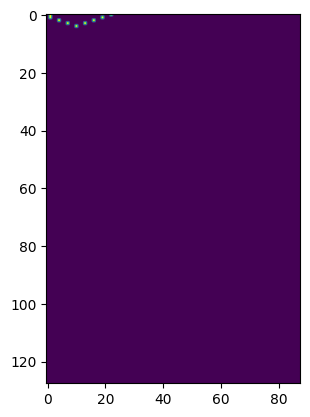

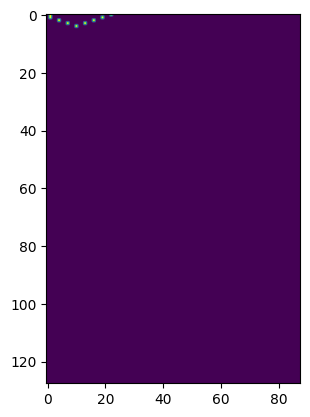

True


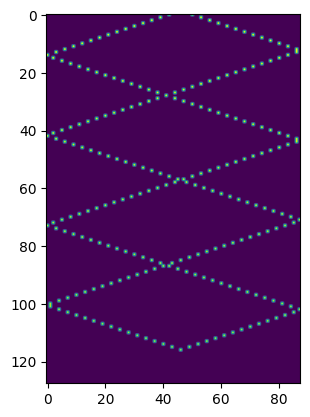

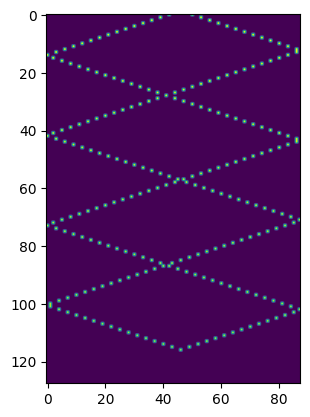

False


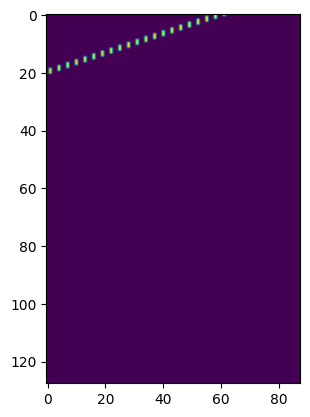

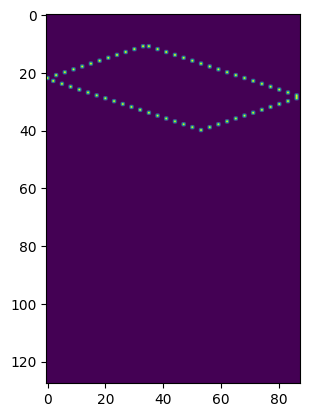

False


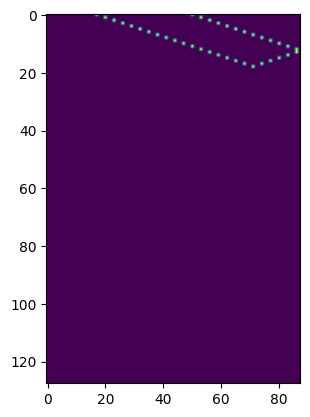

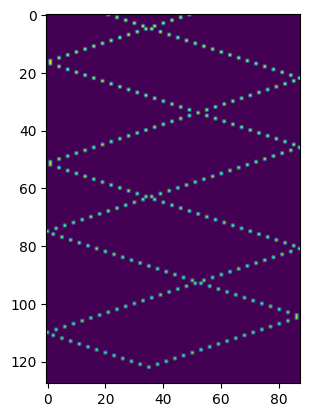

False


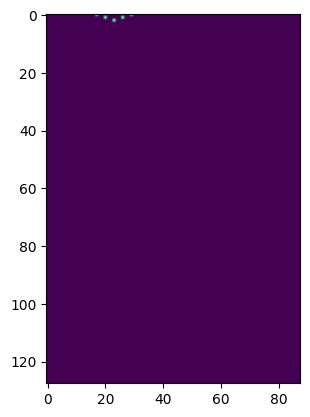

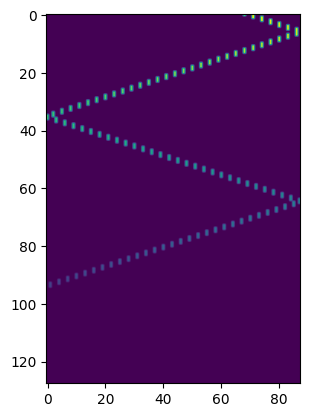

False


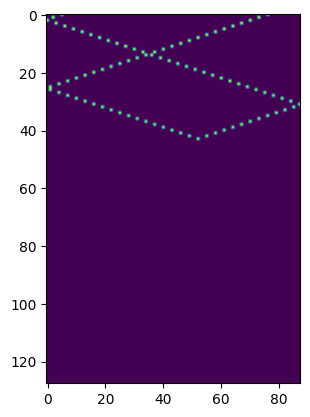

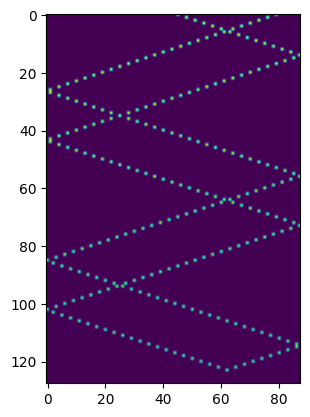

False


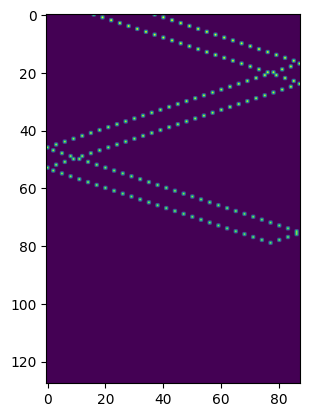

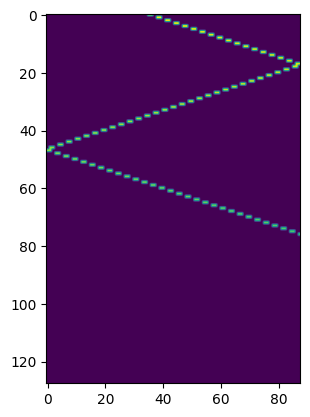

False


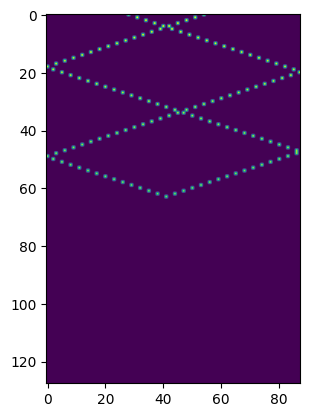

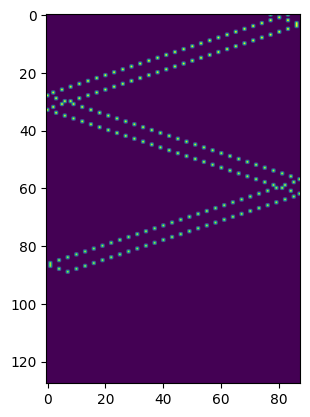

False


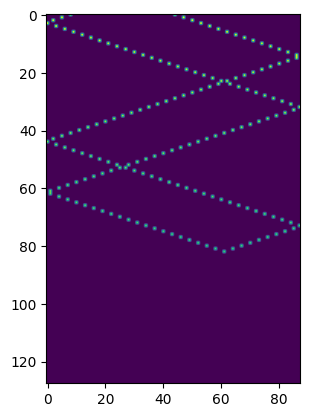

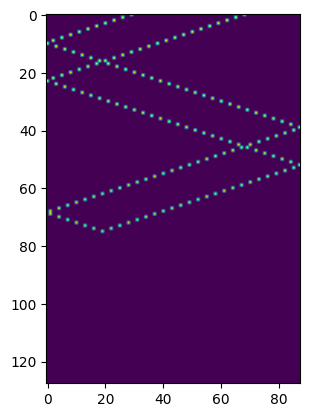

False


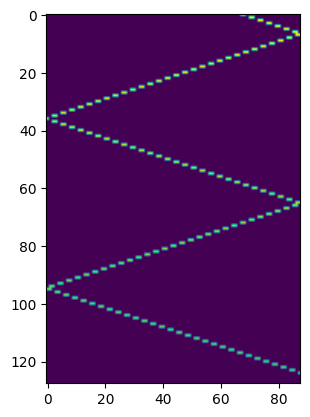

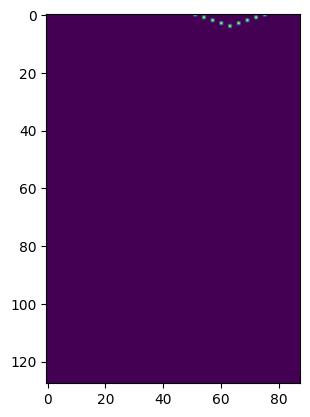

False


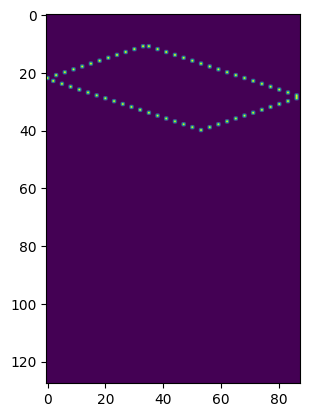

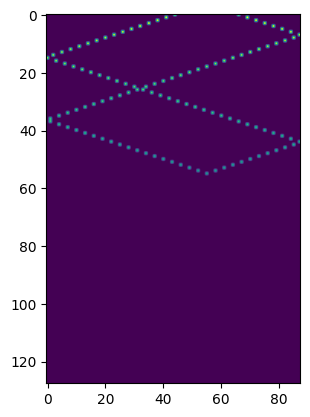

KeyboardInterrupt: 

In [28]:
import os
import torch
import numpy as np
from functools import partial
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from Helper_files.Data_Degradation_Functions import *
from Helper_files.Helper_Functions import input_range_to_random_value
from Dataloader import *

class CustomDataset_V2(Dataset):
    def __init__(self, dir_path, store_full_dataset_in_memory=False, bundle_size=1000):
        self.bundle_size = bundle_size
        self.data_dir = dir_path + "/Data/"
        self.file_list = os.listdir(self.data_dir)
        self.load_from_memory = store_full_dataset_in_memory
        if store_full_dataset_in_memory:
            self.load_data_into_memory()

    def load_data_into_memory(self):
        self.data = torch.cat([torch.load(self.data_dir + file_name) for file_name in tqdm(self.file_list, desc="Loading data into memory", leave=False, unit="Sample Bundle (1000 Files)")], dim=0)

    def get_bundle(self, bundle_index):
        self.data_bundle = torch.load(self.data_dir + self.file_list[bundle_index])

    def __getitem__(self, index):         # UPDATE METHOD TO DIRECTLY RETURN BATCHES?????
        if self.load_from_memory:
            sample = self.data[index]

        else:
            sample_bundle_index = index // self.bundle_size
            sample_index_in_bundle = index % self.bundle_size

            # call load bundle function if index is 0 or a multiple of bundle_size
            if sample_index_in_bundle == 0:
                self.get_bundle(sample_bundle_index)

            # load sample from bundle
            sample = self.data_bundle[sample_index_in_bundle]                                           

        return sample
    
    def __len__(self):
        return len(self.file_list) * self.bundle_size

class CustomDataLoader_V2(DataLoader):
    def __init__(self, input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision, *args, **kwargs):
        super(CustomDataLoader_V2, self).__init__(*args, **kwargs)
        self.input_signal_settings = input_signal_settings
        self.physical_scale_parameters = physical_scale_parameters
        self.time_dimension = time_dimension
        self.device = device
        self.preprocess_on_gpu = preprocess_on_gpu
        self.precision = precision
        
        
    def __iter__(self):
        return CustomDataLoaderIter_V2(self, self.input_signal_settings, self.physical_scale_parameters, self.time_dimension, self.device, self.preprocess_on_gpu, self.precision)

class CustomDataLoaderIter_V2:
    def __init__(self, loader, input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision):
        self.loader = loader
        self.collate_fn = loader.collate_fn
        self.batch_sampler = loader.batch_sampler
        self.dataset = loader.dataset
        self.index_generator = loader._get_iterator()
        self.sample_iter = iter(self.batch_sampler)
        self.input_signal_settings = input_signal_settings
        self.physical_scale_parameters = physical_scale_parameters
        self.time_dimension = time_dimension
        self.set_dtype(precision)
        self.preprocess_on_gpu = preprocess_on_gpu
        if self.preprocess_on_gpu:
            self.device = device
        else:
            self.device = torch.device("cpu")
    
    def set_dtype(self, precision):
        if precision == 16:
            self.dtype = torch.float16
        elif precision == 32:
            self.dtype = torch.float32
        elif precision == 64:
            self.dtype = torch.float64
        else:
            raise ValueError("Invalid dataloader 'precision' value selected. Please select 16, 32, or 64 which correspond to torch.float16, torch.float32, and torch.float64 respectively.")      
          

    def _custom_processing(self, batch):
        signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points = self.input_signal_settings
        signal_settings = input_range_to_random_value(signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points) 
        degraded_batches = signal_degredation(signal_settings, batch, self.physical_scale_parameters, self.time_dimension, self.device, self.dtype)
        return degraded_batches   

    def __iter__(self):
        return self

    def __next__(self):
        indices = next(self.sample_iter)
        batch = self.collate_fn([self.dataset[i] for i in indices])
        batch = batch.to(self.dtype)
        batch = batch.to(self.device)

        sparse_output_batch, sparse_and_resolution_limited_batch, noised_sparse_reslimited_batch = self._custom_processing(batch)

        return batch, sparse_output_batch, sparse_and_resolution_limited_batch, noised_sparse_reslimited_batch


# # Test the custom dataset class
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    from torchvision import transforms
    from torch.utils.data import DataLoader

    time_dimension = 100
    physical_scale_parameters = [0.1, 0.1, 0.1]

    preprocess_on_gpu = True   # Only woirks if cuda gpu is found, else will defulat back to cpu preprocess
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    store_full_dataset_in_memory = True
    precision = 32
    batch_size = 1000
    signal_points = 150 
    noise_points = 20
    x_std_dev = 0
    y_std_dev = 0
    tof_std_dev = 5
    input_signal_settings = [signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points]

    # Create dataset
    dataset = CustomDataset("N:\Yr 3 Project Datasets\RDT 50KM Fix", precision, store_full_dataset_in_memory)
    dataset2 = CustomDataset_V2("N:\Yr 3 Project Datasets\[V2]RDT 50KM Fix", store_full_dataset_in_memory)

    # Create dataloader
    dataloader = CustomDataLoader(input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision, dataset, batch_size, shuffle=False, num_workers=0)
    dataloader2 = CustomDataLoader_V2(input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision, dataset2, batch_size, shuffle=False, num_workers=0)

    # Get a batch of data
    for sample_batched1, sample_batched2 in zip(dataloader, dataloader2):
        print(torch.allclose(sample_batched1[0], sample_batched2[0]))
        plt.imshow(sample_batched1[0][0][0].cpu().numpy())
        plt.show()
        plt.imshow(sample_batched2[0][0][0].cpu().numpy())
        plt.show()
    print("Finished")

In [34]:

time_dimension = 100
physical_scale_parameters = [0.1, 0.1, 0.1]

preprocess_on_gpu = True   # Only woirks if cuda gpu is found, else will defulat back to cpu preprocess
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
store_full_dataset_in_memory = False
precision = 32
batch_size = 1
signal_points = 150 
noise_points = 20
x_std_dev = 0
y_std_dev = 0
tof_std_dev = 5
input_signal_settings = [signal_points, x_std_dev, y_std_dev, tof_std_dev, noise_points]

# Create dataset
dataset = CustomDataset("N:\Yr 3 Project Datasets\RDT 50KM Fix", precision, store_full_dataset_in_memory)
dataset2 = CustomDataset_V2("N:\Yr 3 Project Datasets\[V2]RDT 50KM Fix", store_full_dataset_in_memory)

# Create dataloader
dataloader = CustomDataLoader(input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision, dataset, batch_size, shuffle=False, num_workers=0)
dataloader2 = CustomDataLoader_V2(input_signal_settings, physical_scale_parameters, time_dimension, device, preprocess_on_gpu, precision, dataset2, batch_size, shuffle=False, num_workers=0)


def run_test(dataloader):
    for sample_batch in tqdm(dataloader):
        pass
    print("Finished")


import timeit

In [35]:
import timeit

# Measure the execution time for dataloader
time_taken_dataloader = timeit.timeit('run_test(dataloader)', globals=globals(), number=1)

# Measure the execution time for dataloader2
time_taken_dataloader2 = timeit.timeit('run_test(dataloader2)', globals=globals(), number=1)

print(f"Time taken for dataloader: {time_taken_dataloader} seconds")
print(f"Time taken for dataloader2: {time_taken_dataloader2} seconds")

100%|██████████| 50000/50000 [03:18<00:00, 251.93it/s]


Finished


100%|██████████| 50000/50000 [02:47<00:00, 299.15it/s]

Finished
Time taken for dataloader: 198.4764725000059 seconds
Time taken for dataloader2: 167.14386979999836 seconds
